In [2]:
import sys 
sys.path.append("../build/src/Interpolation_Module")

In [3]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import interpolation_bindings as ib 

In [4]:
quadratic_data = pd.read_csv("../data/quadratic_data.csv")
quadratic_points = ib.df_to_set_of_points(quadratic_data)

cubic_data = pd.read_csv("../data/cubic_data.csv")
cubic_points = ib.df_to_set_of_points(cubic_data)

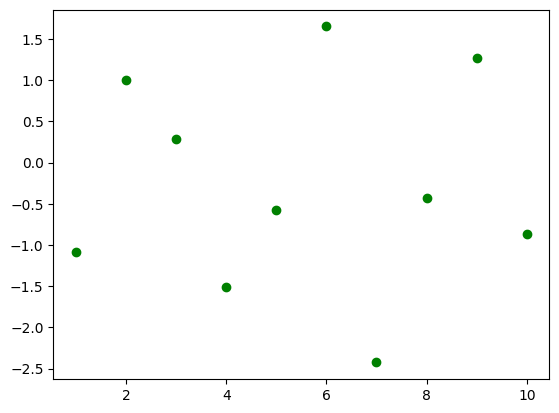

In [5]:
np.random.seed(123)
## creating 10 random values with mean 0
y = np.random.randn(10)
## taking as x the values from 1 to 10
x = np.arange(1, 11)
random_data = pd.DataFrame({"x": x, "y": y})
random_points = ib.df_to_set_of_points(random_data)

plt.plot(random_data["x"], random_data["y"], 'go', label="Random Data")

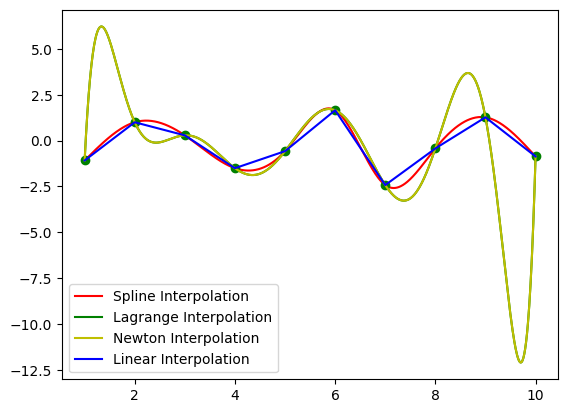

In [6]:
## creating 1000 values between the min and max of the x values of the data
spline = ib.SplineInterpolation(random_points)
x_values = np.linspace(cubic_data["x"].min(), cubic_data["x"].max(), 1000)
y_values = [spline.interpolate(x) for x in x_values]
plt.plot(x_values, y_values, 'r-', label="Spline Interpolation")
## plotting the initial points
plt.plot(random_data["x"], random_data["y"], 'go')

## plotting lagrange
lagrange_interpolation = ib.Lagrange(random_points)
y_lagrange = [lagrange_interpolation.interpolate(x) for x in x_values]
plt.plot(x_values, y_lagrange, 'g-', label="Lagrange Interpolation")

## newton
newton_interpolation = ib.Newton(random_points)
y_newton = [newton_interpolation.interpolate(x) for x in x_values]
plt.plot(x_values, y_newton, 'y-', label="Newton Interpolation")

# linear interpolation
linear_interpolation = ib.LinearInterpolation(random_points)
y_linear = [linear_interpolation.interpolate(x) for x in x_values]
plt.plot(x_values, y_linear, 'b-', label="Linear Interpolation")

plt.legend()

In [7]:
def visualise_interpolation(data):
    points = ib.df_to_set_of_points(data)

    linear_interpolation = ib.LinearInterpolation(points)
    lagrange_interpolation = ib.Lagrange(points)
    newton_interpolation = ib.Newton(points)
    spline = ib.SplineInterpolation(points)

    x_values = np.linspace(data["x"].min(), data["x"].max(), 10000)
    y_linear = [linear_interpolation.interpolate(x) for x in x_values]
    y_lagrange = [lagrange_interpolation.interpolate(x) for x in x_values]
    y_newton = [newton_interpolation.interpolate(x) for x in x_values]
    y_spline = [spline.interpolate(x) for x in x_values]

    plt.plot(data["x"], data["y"], 'go', label="Data")
    plt.plot(x_values, y_linear, 'b-', label="Linear Interpolation")
    plt.plot(x_values, y_lagrange, 'g-', label="Lagrange Interpolation")
    plt.plot(x_values, y_newton, 'y-', label="Newton Interpolation")
    plt.plot(x_values, y_spline, 'r-', label="Spline Interpolation")

    plt.legend()

In [8]:
def generate_data(func, n_points, x_min, x_max):
    x = np.linspace(x_min, x_max, n_points)
    y = func(x)
    return pd.DataFrame({"x": x, "y": y})

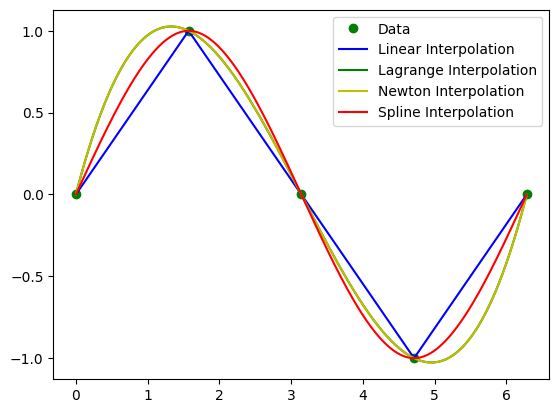

In [11]:
data = generate_data(lambda x: np.sin(x), 5, 0, 2*np.pi)
visualise_interpolation(data)

Accuracy Test

In [40]:
def test_accuracy():
    def mae(y1, y2):
        return np.mean(np.abs(y1 - y2))
    true_x = np.arange(0, 2*np.pi, 5)
    true_y = np.sin(true_x)
    true_points = ib.df_to_set_of_points(pd.DataFrame({"x": true_x, "y": true_y}))
    sparse_x = np.linspace(0, 2*np.pi, 10)
    sparse_y = np.sin(sparse_x)
    sparse_points = ib.df_to_set_of_points(pd.DataFrame({"x": sparse_x, "y": sparse_y}))

    linear_interpolation = ib.LinearInterpolation(sparse_points)
    y_linear = [linear_interpolation.interpolate(x) for x in true_x]

    lagrange_interpolation = ib.Lagrange(sparse_points)
    y_lagrange = [lagrange_interpolation.interpolate(x) for x in true_x]

    newton_interpolation = ib.Newton(sparse_points)
    y_newton = [newton_interpolation.interpolate(x) for x in true_x]

    spline = ib.SplineInterpolation(sparse_points)
    y_spline = [spline.interpolate(x) for x in true_x]

    print(f"Linear Interpolation MAE: {mae(true_y, y_linear)}")
    print(f"Lagrange Interpolation MAE: {mae(true_y, y_lagrange)}")
    print(f"Newton Interpolation MAE: {mae(true_y, y_newton)}")
    print(f"Spline Interpolation MAE: {mae(true_y, y_spline)}")

In [41]:
test_accuracy()

Linear Interpolation MAE: 0.014757179249395291
Lagrange Interpolation MAE: 1.0337615531930133e-06
Newton Interpolation MAE: 1.0337615528044353e-06
Spline Interpolation MAE: 7.889599652244339e-05


Testing order of convergence

In [38]:
# MAE calculation
def mae(y1, y2):
    return np.mean(np.abs(y1 - y2))

# Test Order of Convergence for Linear Interpolation
def test_ooc(interpolation_type):
    if interpolation_type == "linear":
        # Generate true function points
        true_x = np.arange(0, 4 * np.pi, 0.1)
        true_y = np.sin(true_x)

        # Initialize variables
        n_points = 3
        points = []
        mae_results = []

        for _ in range(10):  # Iterate over different point densities
            sparse_x = np.linspace(0, 4 * np.pi, n_points)
            sparse_y = np.sin(sparse_x)
            sparse_points = ib.df_to_set_of_points(pd.DataFrame({"x": sparse_x, "y": sparse_y}))

            # Perform interpolation
            linear_interpolation = ib.LinearInterpolation(sparse_points)
            y_linear = [linear_interpolation.interpolate(x) for x in true_x]

            # Compute and store results
            points.append(n_points)
            mae_results.append(mae(true_y, y_linear))

            n_points *= 2  # Double the points for next iteration

        # Compute order of convergence
        order_of_convergence = [
            np.log2(mae_results[i - 1] / mae_results[i]) for i in range(1, len(mae_results))
        ]

        # Plot results
        fig, ax1 = plt.subplots()

        # MAE results
        ax1.plot(points, mae_results, 'b-o', label="MAE")
        ax1.set_xlabel('Number of Points')
        ax1.set_ylabel('MAE', color='b')
        ax1.tick_params('y', colors='b')
        ax1.set_xscale('log')  # Log scale for better visualization
        ax1.legend(loc='upper left')

        # Order of convergence
        ax2 = ax1.twinx()
        ax2.plot(points[1:], order_of_convergence, 'r-s', label="Order of Convergence")
        ax2.set_ylabel('Order of Convergence', color='r')
        ax2.tick_params('y', colors='r')
        ax2.legend(loc='upper right')

        plt.title(f"Order of Convergence ({interpolation_type.capitalize()})")
        plt.show()
    elif interpolation_type == "lagrange":
        # Generate true function points
        true_x = np.arange(0, 4 * np.pi, 0.1)
        true_y = np.sin(true_x)

        # Initialize variables
        n_points = 3
        points = []
        mae_results = []

        for _ in range(10):
            sparse_x = np.linspace(0, 4 * np.pi, n_points)
            sparse_y = np.sin(sparse_x)
            sparse_points = ib.df_to_set_of_points(pd.DataFrame({"x": sparse_x, "y": sparse_y}))

            # Perform interpolation
            lagrange_interpolation = ib.Lagrange(sparse_points)
            y_lagrange = [lagrange_interpolation.interpolate(x) for x in true_x]

            # Compute and store results
            points.append(n_points)
            mae_results.append(mae(true_y, y_lagrange))

            n_points *= 2

        # Compute order of convergence
        order_of_convergence = [
            np.log2(mae_results[i - 1] / mae_results[i]) for i in range(1, len(mae_results))
        ]

        # Plot results
        fig, ax1 = plt.subplots()

        # MAE results
        ax1.plot(points, mae_results, 'b-o', label="MAE")
        ax1.set_xlabel('Number of Points')
        ax1.set_ylabel('MAE', color='b')
        ax1.tick_params('y', colors='b')
        ax1.set_xscale('log')
        ax1.legend(loc='upper left')

        # Order of convergence
        ax2 = ax1.twinx()
        ax2.plot(points[1:], order_of_convergence, 'r-s', label="Order of Convergence")
        ax2.set_ylabel('Order of Convergence', color='r')
        ax2.tick_params('y', colors='r')
        ax2.legend(loc='upper right')

        plt.title(f"Order of Convergence ({interpolation_type.capitalize()})")
        plt.show()

    elif interpolation_type == "newton":

        # Generate true function points
        true_x = np.arange(0, 4 * np.pi, 0.1)
        true_y = np.sin(true_x)

        # Initialize variables
        n_points = 3
        points = []
        mae_results = []

        for _ in range(10):
            sparse_x = np.linspace(0, 4 * np.pi, n_points)
            sparse_y = np.sin(sparse_x)
            sparse_points = ib.df_to_set_of_points(pd.DataFrame({"x": sparse_x, "y": sparse_y}))

            # Perform interpolation
            newton_interpolation = ib.Newton(sparse_points)
            y_newton = [newton_interpolation.interpolate(x) for x in true_x]

            # Compute and store results
            points.append(n_points)
            mae_results.append(mae(true_y, y_newton))

            n_points *= 2

        # Compute order of convergence
        order_of_convergence = [
            np.log2(mae_results[i - 1] / mae_results[i]) for i in range(1, len(mae_results))
        ]

        # Plot results
        fig, ax1 = plt.subplots()

        # MAE results
        ax1.plot(points, mae_results, 'b-o', label="MAE")
        ax1.set_xlabel('Number of Points')
        ax1.set_ylabel('MAE', color='b')
        ax1.tick_params('y', colors='b')
        ax1.set_xscale('log')
        ax1.legend(loc='upper left')

        # Order of convergence
        ax2 = ax1.twinx()
        ax2.plot(points[1:], order_of_convergence, 'r-s', label="Order of Convergence")
        ax2.set_ylabel('Order of Convergence', color='r')
        ax2.tick_params('y', colors='r')
        ax2.legend(loc='upper right')

        plt.title(f"Order of Convergence ({interpolation_type.capitalize()})")
        plt.show()

    elif interpolation_type == "spline":

        # Generate true function points
        true_x = np.arange(0, 4 * np.pi, 0.1)
        true_y = np.sin(true_x)

        # Initialize variables
        n_points = 3
        points = []
        mae_results = []

        for _ in range(10):
            sparse_x = np.linspace(0, 4 * np.pi, n_points)
            sparse_y = np.sin(sparse_x)
            sparse_points = ib.df_to_set_of_points(pd.DataFrame({"x": sparse_x, "y": sparse_y}))

            # Perform interpolation
            spline = ib.SplineInterpolation(sparse_points)
            y_spline = [spline.interpolate(x) for x in true_x]

            # Compute and store results
            points.append(n_points)
            mae_results.append(mae(true_y, y_spline))

            n_points *= 2

        # Compute order of convergence
        order_of_convergence = [
            np.log2(mae_results[i - 1] / mae_results[i]) for i in range(1, len(mae_results))
        ]

        # Plot results
        fig, ax1 = plt.subplots()

        # MAE results
        ax1.plot(points, mae_results, 'b-o', label="MAE")
        ax1.set_xlabel('Number of Points')
        ax1.set_ylabel('MAE', color='b')
        ax1.tick_params('y', colors='b')
        ax1.set_xscale('log')
        ax1.legend(loc='upper left')

        # Order of convergence
        ax2 = ax1.twinx()
        ax2.plot(points[1:], order_of_convergence, 'r-s', label="Order of Convergence")
        ax2.set_ylabel('Order of Convergence', color='r')
        ax2.tick_params('y', colors='r')
        ax2.legend(loc='upper right')

        plt.title(f"Order of Convergence ({interpolation_type.capitalize()})")
        plt.show()
        


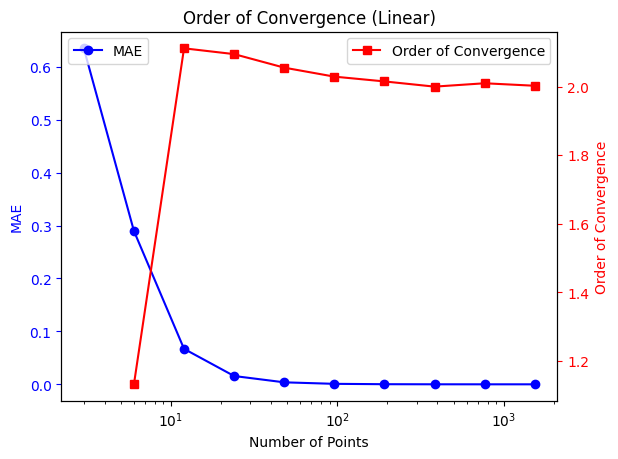

In [35]:
# Example Usage
test_ooc("linear")

/var/folders/36/dqn14xy95j93q4nqhpjrg0s80000gn/T/ipykernel_94990/2548311013.py:84: RuntimeWarning: divide by zero encountered in log2
  np.log2(mae_results[i - 1] / mae_results[i]) for i in range(1, len(mae_results))


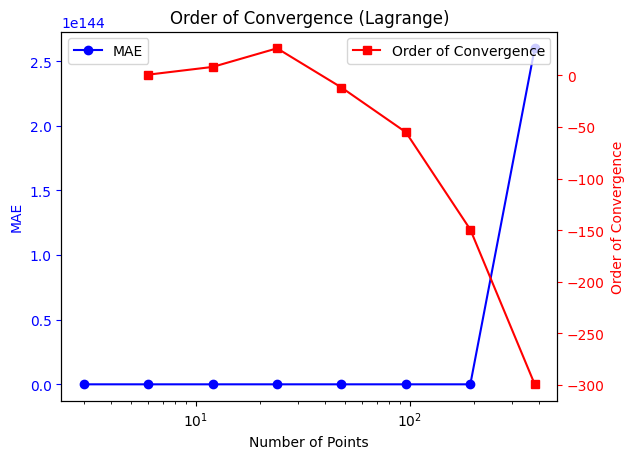

In [40]:
test_ooc("lagrange")

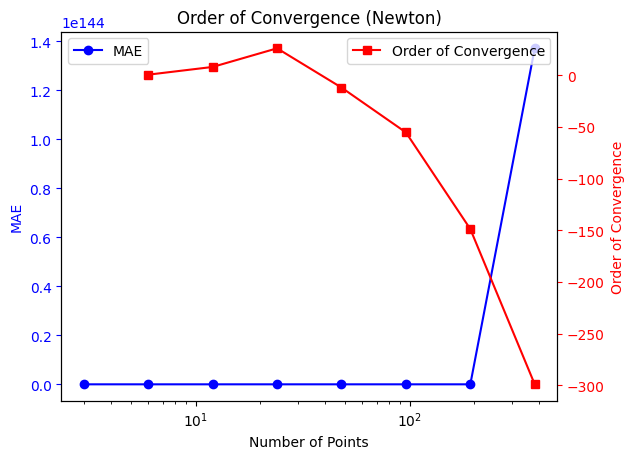

In [41]:
test_ooc("newton")

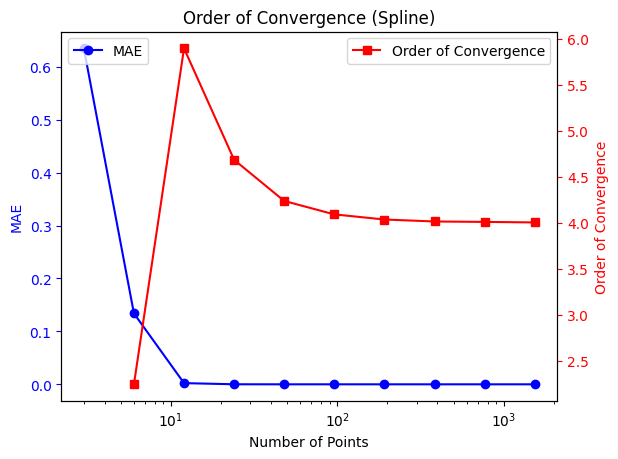

In [42]:
test_ooc("spline")